<a href="https://colab.research.google.com/github/gmberton/image-matching-models/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# installs, this may take awhile
!git clone --quiet --recursive https://github.com/gmberton/image-matching-models
%cd image-matching-models
!pip install --progress-bar off --quiet -e .
!pip install -r requirements.txt --quiet --progress-bar off


fatal: No url found for submodule path 'third_party/silk/external/URR' in .gitmodules
fatal: Failed to recurse into submodule path 'third_party/silk'
/content/image-matching-models/image-matching-models
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for image-matching-models (pyproject.toml) ... done


In [7]:
from matching import get_matcher, viz2d, available_models
from pathlib import Path
import torch
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from kornia import tensor_to_image
import warnings
from PIL import Image
from kornia import tensor_to_image
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
matcher = get_matcher('sift-lg', device=device)

Using device: cpu


Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/sift_lightglue.pth" to /root/.cache/torch/hub/checkpoints/sift_lightglue_v0-1_arxiv.pth
100%|██████████| 45.4M/45.4M [00:00<00:00, 133MB/s]


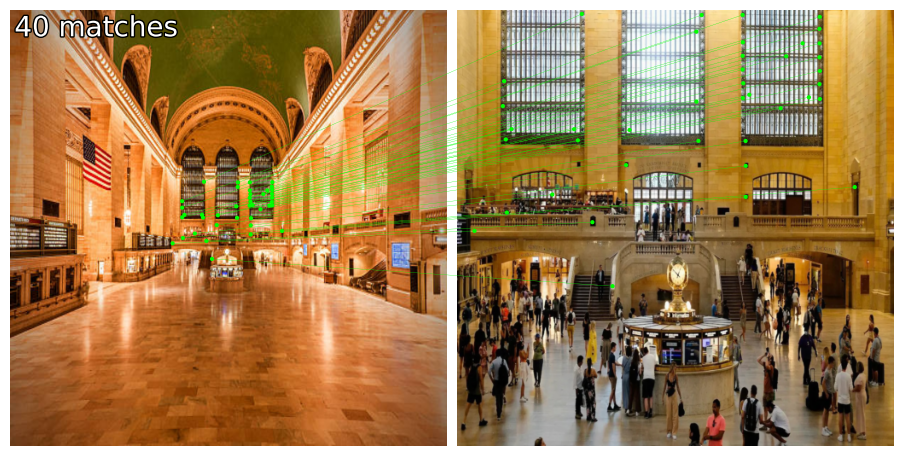

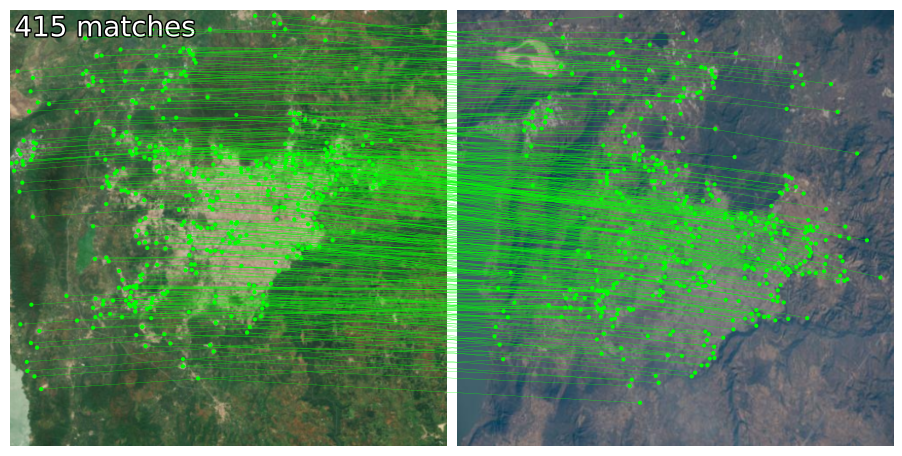

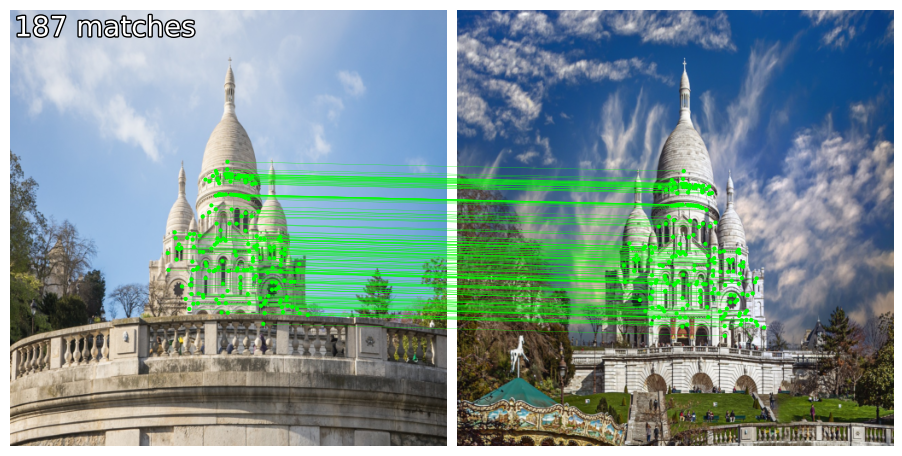

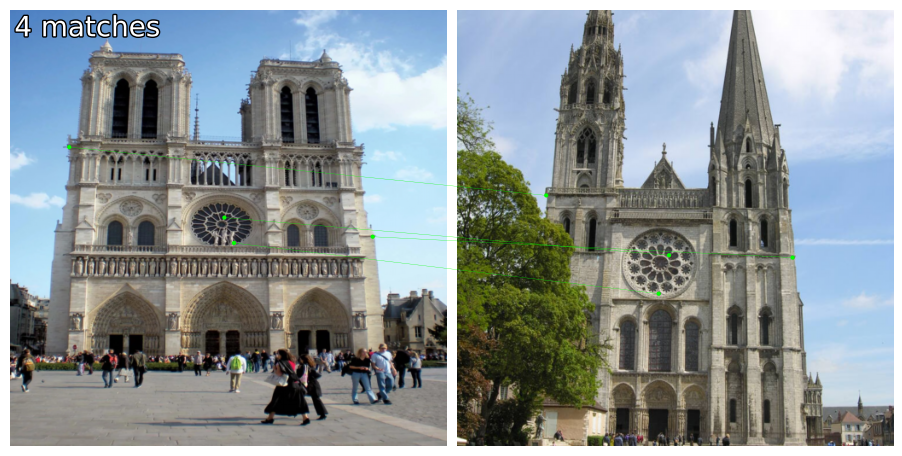

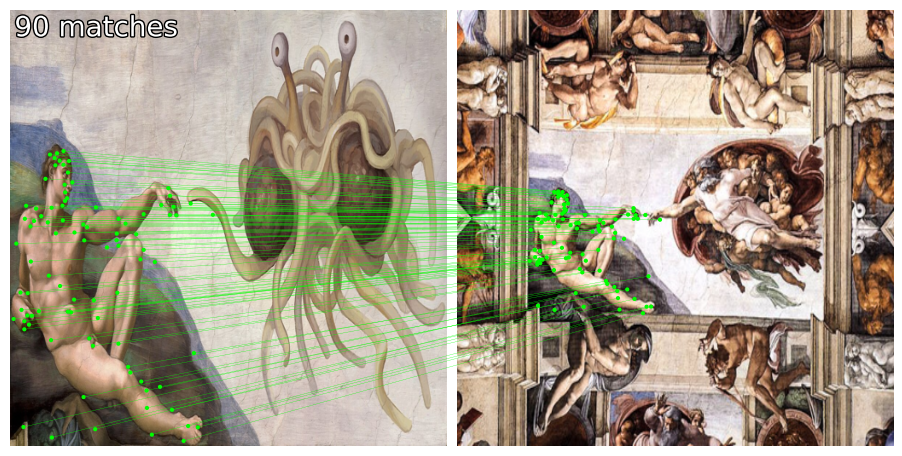

In [9]:
asset_dir = Path('assets/example_pairs')
pairs = list(asset_dir.iterdir())
image_size = 512
for pair in pairs:
    pair = list(pair.iterdir())
    img0 = matcher.image_loader(pair[0], resize=image_size).to(device)
    img1 = matcher.image_loader(pair[1], resize=image_size).to(device)

    num_inliers, H, mkpts0, mkpts1 = matcher(img0, img1)
    axes = viz2d.plot_images([img0, img1])
    viz2d.plot_matches(mkpts0, mkpts1, color='lime', lw=0.2)
    viz2d.add_text(0, f'{len(mkpts1)} matches', fs=20)


### See all matchers on the same image pair

In [ ]:
%%capture

image_size = 512
img0 = matcher.image_loader(pair[0], resize=image_size).to(device)
img1 = matcher.image_loader(pair[1], resize=image_size).to(device)
num_per_row = 3
fig, axs = plt.subplots(int(np.ceil(len(available_models)/num_per_row)), 2*num_per_row, figsize=(12, 20))
flat_axs = axs.flatten()

for idx, model in enumerate(available_models):
    idx = idx * 2
    ax0, ax1 = flat_axs[idx], flat_axs[idx+1]

    try:
        matcher = get_matcher(model, device=device)
        num_inliers, H, mkpts0, mkpts1 = matcher(img0, img1)
        ax0.imshow(tensor_to_image(img0))
        ax1.imshow(tensor_to_image(img1))
        _ = viz2d.plot_matches(mkpts0, mkpts1, color='lime', lw=0.1, ps=1, axes=[ax0, ax1])
        ax0.text(image_size/2, -10, f'{model}: {len(mkpts1)} matches')

    except Exception as e:
        blank_img = np.zeros_like(tensor_to_image(img0))
        ax0.imshow(blank_img)
        ax1.imshow(blank_img)
        ax0.text(image_size/2, -10, f'{model}: Error')
        print(f'Error with {model}: {e}')

for ax in flat_axs:
    ax.axis('off')

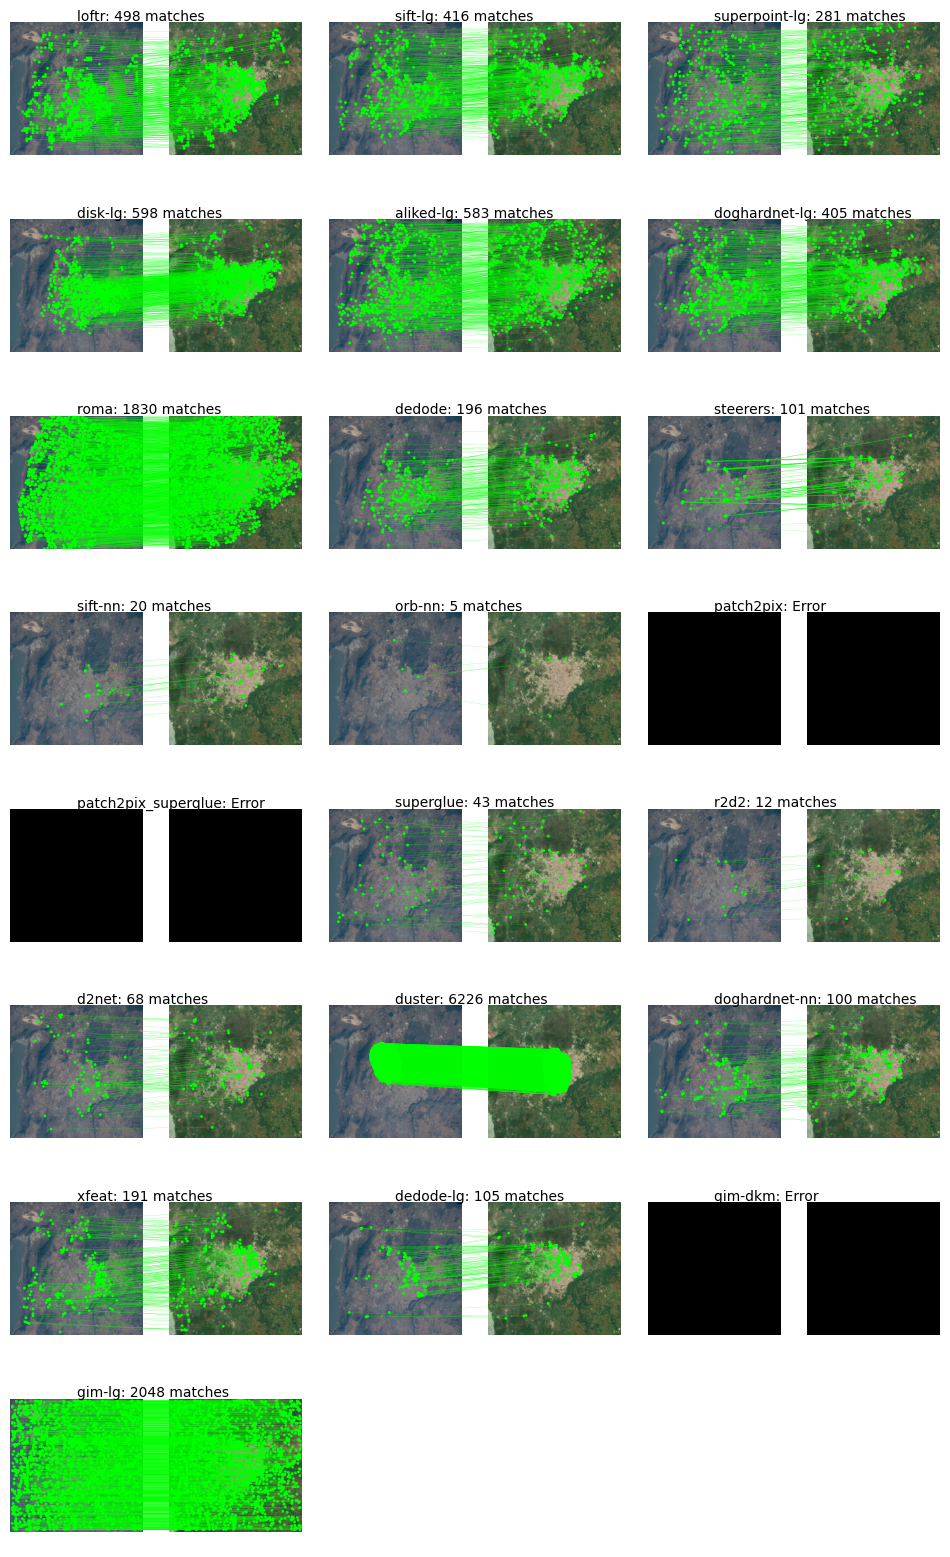

In [ ]:
fig